In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')
palette = sns.husl_palette(s=1)
sns.set(style='whitegrid', palette=palette, context='talk')

### Feature Engineering Function

In [44]:
def feat_eng(X):
    # Create additional features
    X_t = X
    X_t['atemp_shift'] = abs(X_t['atemp'] - 35)
    X_t['datetime'] = pd.to_datetime(X_t['datetime'])
    # Extract all time information
    X_t['datetime_hour'] = X_t['datetime'].dt.hour # important _ onehot
    X_t['datetime_day'] = X_t['datetime'].dt.day
    X_t['datetime_month'] = X_t['datetime'].dt.month # use month as onehot or factorized instead of season
    X_t['datetime_year'] = X_t['datetime'].dt.year # maybe instead of timestamp
    X_t['datetime_weekdays'] = X['datetime'].dt.day_name()
    X_t['timestamp'] = X_t['datetime'].astype(int) / 1_000_000_000_000_000_000
    X_t['hour_workday'] = X_t['datetime_hour'] * X_t['workingday']
    X_t['hour_weekend'] = X_t['datetime_hour'] * (X_t['workingday'] - 1) * (-1)
    return X_t

### Load data

In [45]:
df = pd.read_csv('train.csv', parse_dates=True)
df_test = pd.read_csv('test.csv', parse_dates=True)

### Train-test-split

In [46]:
X = df.copy()
X_test = df_test.copy()
y = df['count'].values

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

X_train.reset_index(inplace=True)
X_train_stored = X_train.copy()
X_val.reset_index(inplace=True)
X_test.reset_index(inplace=True)
X.reset_index(inplace=True)

y_train_cas = X_train['casual']
y_train_reg = X_train['registered']
y_cas = X['casual']
y_reg = X['registered']

In [47]:
# Feature Engineer
X_train = feat_eng(X_train)
X_val = feat_eng(X_val)
X_test = feat_eng(X_test)
X = feat_eng(X)

In [48]:
# One-Hot-Encoding
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False, drop='first')
onehot_features = ['datetime_month', 'weather', 'hour_workday', 'hour_weekend']
ohc.fit(X_train[onehot_features])
onehot_columns = ohc.get_feature_names(['month', 'weather', 'hour_workday', 'hour_weekend'])

# Make dataframes of one-hot-encoded features and give column names
X_train_onehot = ohc.transform(X_train[onehot_features])
X_train_onehot = pd.DataFrame(X_train_onehot, columns=onehot_columns)

X_val_onehot = ohc.transform(X_val[onehot_features])
X_val_onehot = pd.DataFrame(X_val_onehot, columns=onehot_columns)

X_test_onehot = ohc.transform(X_test[onehot_features])
X_test_onehot = pd.DataFrame(X_test_onehot, columns=onehot_columns)

X_onehot = ohc.transform(X[onehot_features])
X_onehot = pd.DataFrame(X_onehot, columns=onehot_columns)

In [49]:
# Select features from original data and concatenate with one-hot-encoded features
features = ['timestamp', 'workingday', 'atemp', 'humidity', 'windspeed']

X_train = X_train[features]
X_train = pd.concat([X_train, X_train_onehot], axis=1)

X_val = X_val[features]
X_val = pd.concat([X_val, X_val_onehot], axis=1)

X_test = X_test[features]
X_test = pd.concat([X_test, X_test_onehot], axis=1)

X = X[features]
X = pd.concat([X, X_onehot], axis=1)

## Set up the model

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
lr_cas = LinearRegression()
lr_cas.fit(X_train, np.log(y_train_cas+1))
lr_cas.score(X_train, np.log(y_train_cas+1))

0.8537182133269399

In [52]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, np.log(y_train_reg+1))
lr_reg.score(X_train, np.log(y_train_reg+1))

0.9398494250972024

Cross validation

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_reg, X_train, np.log(y_train_reg+1), cv=4, scoring='r2')
scores

array([-1.15774268e+15,  9.37893884e-01,  9.34762015e-01,  9.38430130e-01])

In [54]:
scores.mean().round(3), scores.std().round(3)

(-289435670381420.8, 501317286623381.06)

In [55]:
y_pred_cas = np.exp(lr_cas.predict(X_train))
y_pred_reg = np.exp(lr_reg.predict(X_train))
y_pred_count = y_pred_cas + y_pred_reg

In [56]:
X_train

,timestamp,workingday,atemp,humidity,windspeed,month_2,month_3,month_4,month_5,month_6,...,hour_weekend_14,hour_weekend_15,hour_weekend_16,hour_weekend_17,hour_weekend_18,hour_weekend_19,hour_weekend_20,hour_weekend_21,hour_weekend_22,hour_weekend_23
0,1.310724,1,31.060,61,11.0014,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.321211,0,24.240,29,23.9994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.326546,0,10.605,44,19.0012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.307221,0,31.060,47,7.0015,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.310011,1,28.790,89,7.0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,1.328569,1,15.150,65,8.9981,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8704,1.297544,0,15.150,41,0.0000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8705,1.355216,1,15.150,61,26.0027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8706,1.341875,1,32.575,65,7.0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

print('Score for training data')
print('R2 value: ' + str(r2_score(y_train, y_pred_count)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_train, y_pred_count))))

Score for training data
R2 value: 0.8913712987187183
RMSLE: 0.36360970483065774


In [58]:
#lr_reg.coef_, lr_cas.coef_

In [59]:
count_residual = y_pred_count - y_train

In [60]:
result = pd.DataFrame({'y_train':y_train, 'y_pred_count':y_pred_count, 'y_count_residual':count_residual})

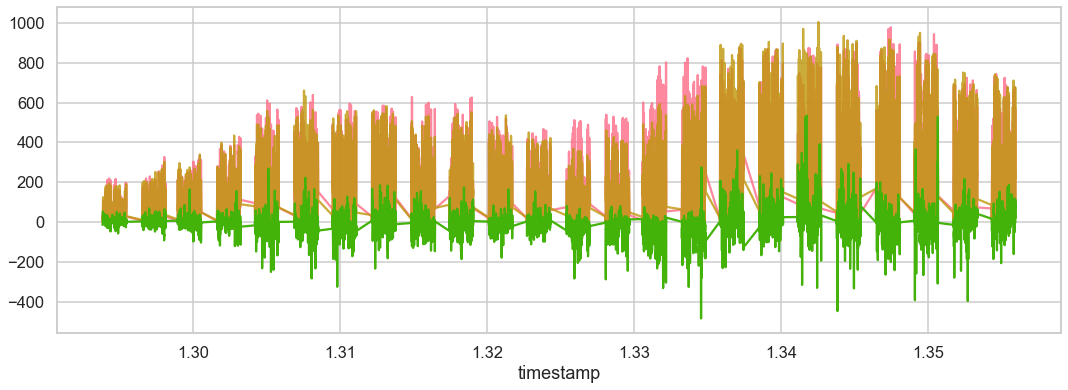

In [20]:
fig = plt.figure(figsize=(18,6))
ax = sns.lineplot(x='timestamp', y=y_train, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=y_pred_count, data=X_train, alpha = 0.8)
ax = sns.lineplot(x='timestamp', y=count_residual, data=X_train)
#ax.set_xlim(pd.Timestamp('2011-04-01'), pd.Timestamp('2011-09-01'))

[Text(0.5, 0, 'Count')]

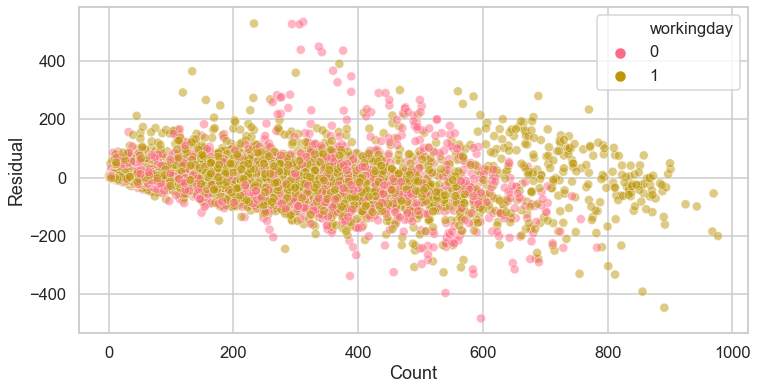

In [29]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x=y_train, y=count_residual, hue='workingday', data=X_train, alpha = 0.5)

ax.set(ylabel='Residual')
ax.set(xlabel='Count')

[Text(0.5, 0, '"Feels like" temperature / °C')]

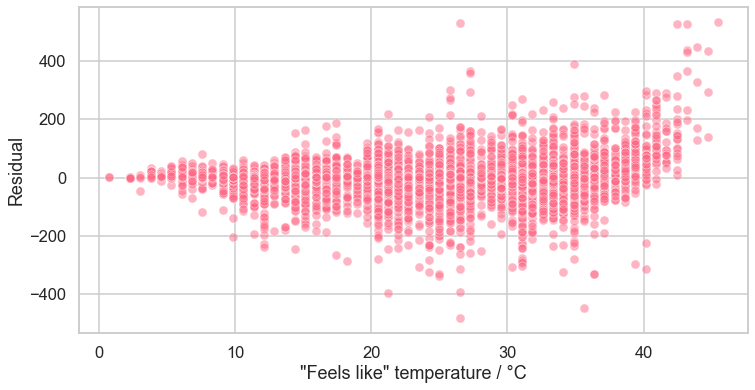

In [30]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='atemp', y=count_residual, data=X_train, alpha = 0.5)


ax.set(ylabel='Residual')
ax.set(xlabel='"Feels like" temperature / °C')

[Text(0.5, 0, '"Feels like" temperature / °C')]

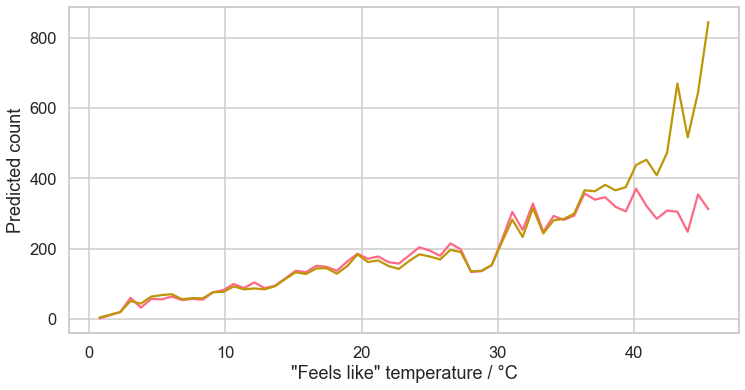

In [41]:
X_train_results = pd.concat([X_train_stored, result], axis=1)
temp = X_train_results.groupby('atemp')[['atemp', 'y_train','y_pred_count', 'y_count_residual']].mean()

plt.figure(figsize=(12,6))
ax = sns.lineplot(x='atemp', y='y_train', data=temp)
sns.lineplot(x='atemp', y='y_pred_count', data=temp)

ax.set(ylabel='Predicted count')
ax.set(xlabel='"Feels like" temperature / °C')

In [36]:
X_train_results

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,y_train,y_pred_count,ycount_residual
0,3036,2011-07-15 10:00:00,3,0,1,2,27.06,31.060,61,11.0014,59,107,166,166,119.087201,-46.912799
1,4817,2011-11-13 19:00:00,4,0,0,1,20.50,24.240,29,23.9994,36,121,157,157,213.288891,56.288891
2,5745,2012-01-14 13:00:00,1,0,0,1,9.02,10.605,44,19.0012,38,182,220,220,169.980574,-50.019426
3,2327,2011-06-04 21:00:00,2,0,0,2,27.06,31.060,47,7.0015,46,139,185,185,142.935910,-42.064090
4,2838,2011-07-07 04:00:00,3,0,1,1,26.24,28.790,89,7.0015,0,4,4,4,6.432155,2.432155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,6017,2012-02-06 23:00:00,1,0,1,1,12.30,15.150,65,8.9981,3,43,46,46,60.705809,14.705809
8704,709,2011-02-12 21:00:00,1,0,0,1,10.66,15.150,41,0.0000,9,42,51,51,63.612936,12.612936
8705,10679,2012-12-11 09:00:00,4,0,1,1,13.94,15.150,61,26.0027,12,322,334,334,310.523705,-23.476295
8706,8366,2012-07-09 23:00:00,3,0,1,2,28.70,32.575,65,7.0015,22,109,131,131,123.059669,-7.940331


In [28]:
#X_train[count_residual > 300]

In [26]:
# Score on validation data!

y_pred_cas_val = np.exp(lr_cas.predict(X_val))
y_pred_reg_val = np.exp(lr_reg.predict(X_val))
y_pred_count_val = y_pred_cas_val + y_pred_reg_val

print('Score for validation data')
print('R2 value: ' + str(r2_score(y_val, y_pred_count_val)))
print('RMSLE: ' + str(np.sqrt(mean_squared_log_error(y_val, y_pred_count_val))))

Score for validation data
R2 value: 0.8914687319036987
RMSLE: 0.37943785129415186


## Train on whole dataset

In [27]:
lr_cas.fit(X, np.log(y_cas+1))
lr_reg.fit(X, np.log(y_reg+1))

lr_cas.score(X, np.log(y_cas+1)), lr_reg.score(X, np.log(y_reg+1))

(0.8539315868287969, 0.9385212988764285)

## Predict values for test data

In [305]:
y_pred_cas_test = np.exp(lr_cas.predict(X_test))
y_pred_reg_test = np.exp(lr_reg.predict(X_test))
y_pred_count_test = y_pred_cas_test + y_pred_reg_test

In [306]:
y_pred_count_test 

array([ 11.57401408,   6.19387451,   3.53668921, ..., 211.54986813,
       165.30391092, 103.07906345])

In [308]:
Kaggle_LinReg01 = pd.DataFrame({'datetime': df_test['datetime'], 'count': y_pred_count_test})
Kaggle_LinReg01.to_csv('Kaggle_LinReg01.csv', index=False)

In [309]:
Kaggle_LinReg01

,datetime,count
0,2011-01-20 00:00:00,11.574014
1,2011-01-20 01:00:00,6.193875
2,2011-01-20 02:00:00,3.536689
3,2011-01-20 03:00:00,2.386467
4,2011-01-20 04:00:00,2.639669
...,...,...
6488,2012-12-31 19:00:00,367.713930
6489,2012-12-31 20:00:00,262.110380
6490,2012-12-31 21:00:00,211.549868
6491,2012-12-31 22:00:00,165.303911


#### Scale the data

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # scales each column to minimum 0.0 and maximum 1.0. Makes sure all data fits together.
scaler.fit(X_train)

X_train = scaler.transform(X_train) # later just use transform on X_test, DO NOT FIT AGAIN
X_val = scaler.transform(X_val)

X_train.head()#.shape, X_val.shape

AttributeError: 'numpy.ndarray' object has no attribute 'head'